# Dependencies

In [ ]:
pip install pdf2image dropbox keras-tuner tensorflow pandas pillow pyyaml h5py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.1/572.1 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.6 MB/s eta 0:00:00


In [ ]:
!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.5 [186 kB]
Fetched 186 kB in 1s (221 kB/s)


# Data Loading and Preprocessing

In [ ]:
#Load image pdfs into local directory from secure Dropbox
import dropbox
from pdf2image import convert_from_bytes
import io

# Define the region coordinates for cropping PDFs (predefined indices of pain sketches within scanned document)
x, y, width, height = 100, 500, 1700, 1000
target_height = 256  # Desired height for the resized images

# Loop over each folder path
for folder_path in folder_paths:
    # List and process PDF files in the Dropbox folder
    for entry in dbx.files_list_folder(folder_path).entries:
        if entry.name.endswith('.pdf'):
            print(f'Processing {entry.name}')

            # Download PDF file into memory
            _, response = dbx.files_download(f'{folder_path}/{entry.name}')

            # Convert only the first page of the PDF to an image
            images = convert_from_bytes(response.content, first_page=1, last_page=1)

            if images:
                image = images[0]  # Get the first page
                # Crop the image
                cropped_image = image.crop((x, y, x + width, y + height))

                # Calculate new width to maintain aspect ratio
                aspect_ratio = cropped_image.width / cropped_image.height
                new_width = int(target_height * aspect_ratio)

                # Resize the image to maintain aspect ratio
                resized_image = cropped_image.resize((new_width, target_height))

                # Convert the image to grayscale
                grayscale_image = resized_image.convert('L')

                # Save the grayscale image as JPEG
                output_filename = f'{entry.name[:-4]}.jpeg'
                grayscale_image.save(output_filename, 'JPEG')

                print(f'Saved {output_filename}')

In [ ]:
# Mirror the images (to avoid laterality bias)
import os
import pandas as pd
from PIL import Image

# Load sketches and ratings (stored here in Excel file, in separate columns named 'sketch' and 'rating')
ratings_df = pd.read_excel('/content/ML_sketch_rating_amp_ASR.xlsx')
image_directory = '/content/sketches'
all_image_files = os.listdir(image_directory)

# Initialize a list to store sketch name and ratings
image_ratings_data = []

# Process each image file in the directory
for f in all_image_files:
    if f.endswith('.jpeg'):
        prefix = f.rsplit('.', 1)[0]  # Split on the last period to remove the extension
        if prefix in ratings_df['sketch'].values:
            # Get the rating from the Excel file
            rating = ratings_df[ratings_df['sketch'] == prefix]['rating'].values[0]

            # Append old image data
            image_ratings_data.append({'Image': prefix + '.jpeg', 'Rating': rating})

            # Load the image
            image_path = os.path.join(image_directory, f)
            img = Image.open(image_path)

            # Create the mirrored image
            mirrored_img = img.transpose(Image.FLIP_LEFT_RIGHT)

            # Save the mirrored image
            mirrored_image_filename = f'{prefix}_mirrored.jpeg'
            new_image_path = os.path.join(image_directory, mirrored_image_filename)
            mirrored_img.save(new_image_path)
            print(f'Mirrored image saved: {new_image_path}')

            # Append new mirrored image data
            image_ratings_data.append({'Image': mirrored_image_filename, 'Rating': rating})

# Create a DataFrame from the image ratings data
full_image_ratings_df = pd.DataFrame(image_ratings_data) ##This is what we're using for model training!

# Display the DataFrame
print(full_image_ratings_df)


Mirrored image saved: /content/sketches/3020224_4_mirrored.jpeg
Mirrored image saved: /content/sketches/5713794_7_mirrored.jpeg
Mirrored image saved: /content/sketches/7436763_1_mirrored.jpeg
Mirrored image saved: /content/sketches/7331515_1_mirrored.jpeg
Mirrored image saved: /content/sketches/3114353_2_mirrored.jpeg
Mirrored image saved: /content/sketches/3020224_5_mirrored.jpeg
Mirrored image saved: /content/sketches/6903405_2_mirrored.jpeg
Mirrored image saved: /content/sketches/1499101_1_mirrored.jpeg
Mirrored image saved: /content/sketches/7269652_4_mirrored.jpeg
Mirrored image saved: /content/sketches/5719258_6_mirrored.jpeg
Mirrored image saved: /content/sketches/7864999_1_mirrored.jpeg
Mirrored image saved: /content/sketches/7453129_3_mirrored.jpeg
Mirrored image saved: /content/sketches/4287657_5_mirrored.jpeg
Mirrored image saved: /content/sketches/7640713_1_mirrored.jpeg
Mirrored image saved: /content/sketches/5227161_1_mirrored.jpeg
Mirrored image saved: /content/sketches/

# Model Training and Validation (Binary Classification)



In [ ]:
import pandas as pd

# Create a DataFrame from the image ratings data
full_image_ratings_df = pd.DataFrame(image_ratings_data)
print(full_image_ratings_df)

# Filter to include only the desired classes (run for each desired pairwise combination of classes; in this case, FP and DP)
selected_classes = ['FP', 'DP']
filtered_df = full_image_ratings_df[full_image_ratings_df['Rating'].isin(selected_classes)]

# Calculate the number of files in each of the selected classes (for manual downsampling based on the minority class)
class_counts = filtered_df['Rating'].value_counts()
print("\nNumber of files in each selected class:")
print(class_counts)
minority_class_count = class_counts.min()

def select_subset(df, column, n_samples=None, classes=None, balance=True):
    """
    Creates a subset of the DataFrame with options to balance and select specific classes.

    Parameters:
    df (DataFrame): The original DataFrame.
    column (str): Column name which contains the class labels.
    n_samples (int, optional): Number of samples to select from each class if balancing is required.
    classes (list, optional): List of classes to include. If None, all classes are included.
    balance (bool): Whether to balance the classes by sampling an equal number of examples.

    Returns:
    DataFrame: A subset DataFrame with specified classes, optionally balanced.
    """
    # If classes to use are not specified, use all classes
    if classes is None:
        classes = df[column].unique()

    # Filter for classes of interest
    df_filtered = df[df[column].isin(classes)]

    if balance and n_samples is not None:
        balanced_df = df_filtered.groupby(column).apply(lambda x: x.sample(n=n_samples, replace=True if len(x) < n_samples else False)).reset_index(drop=True)
        return balanced_df
    else:
        return df_filtered

# Filtered_df is direct input for CNN
filtered_df = select_subset(full_image_ratings_df, 'Rating', n_samples=minority_class_count, classes=selected_classes, balance=True)
print(filtered_df)

                        Image Rating
0              3020224_4.jpeg     NP
1     3020224_4_mirrored.jpeg     NP
2              5713794_7.jpeg     DP
3     5713794_7_mirrored.jpeg     DP
4              7436763_1.jpeg     NP
...                       ...    ...
1163  6351150_5_mirrored.jpeg     DP
1164           7698488_3.jpeg     RP
1165  7698488_3_mirrored.jpeg     RP
1166           7862193_1.jpeg     RP
1167  7862193_1_mirrored.jpeg     RP

[1168 rows x 2 columns]

Number of files in each class:
Rating
DP    552
FP    248
NP    228
RP    140
Name: count, dtype: int64
                       Image Rating
0             6054284_4.jpeg     DP
1    3860076_9_mirrored.jpeg     DP
2             7582983_1.jpeg     DP
3            5713794_11.jpeg     DP
4    5597030_1_mirrored.jpeg     DP
..                       ...    ...
491           7864999_1.jpeg     FP
492           7398359_1.jpeg     FP
493           4929845_3.jpeg     FP
494  7582983_3_mirrored.jpeg     FP
495           3114353_2.jpeg  

In [ ]:
##CNN training/validation
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, BatchNormalization
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Dense, Conv2D, MaxPooling2D, Flatten, multiply, Layer
from tensorflow.keras.utils import register_keras_serializable

# Image Loading
def load_image(file_path):
    img = Image.open(file_path)
    img = img.convert('RGB')  # Convert image to RGB to ensure 3 color channels; necessary for tensorflow
    return np.array(img)

# Encode ratings
label_encoder = LabelEncoder()
encoded_ratings = label_encoder.fit_transform(filtered_df['Rating'])
filtered_df['encoded_ratings'] = encoded_ratings  # Adding encoded ratings to DataFrame
categorical_ratings = to_categorical(encoded_ratings)
filtered_df['categorical_ratings'] = list(categorical_ratings)  # Store as list of arrays

# Append ratings to dataset
image_directory = '/content/sketches'
data = []
labels = []

for index, row in filtered_df.iterrows():
    file_path = os.path.join(image_directory, row['Image'])
    if os.path.exists(file_path):
        img = load_image(file_path)
        data.append(img)
        labels.append(row['categorical_ratings'])

data = np.array(data)
labels = np.array(labels, dtype='float32')  # Ensure correct data type

# Normalize pixel values to be between 0 and 1
data = data.astype('float32') / 255.0

# Split the dataset
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)

# Determine input shape for CNN
input_shape = X_train.shape[1:]

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Define the SqueezeExciteBlock layer
@register_keras_serializable(package='Custom', name='SqueezeExciteBlock')
class SqueezeExciteBlock(Layer):
    def __init__(self, ratio=16, **kwargs):
        super(SqueezeExciteBlock, self).__init__(**kwargs)
        self.ratio = ratio

    def build(self, input_shape):
        self.filters = input_shape[-1]
        self.se = models.Sequential([
            GlobalAveragePooling2D(),
            Dense(self.filters // self.ratio, activation='relu', use_bias=False),
            Dense(self.filters, activation='sigmoid', use_bias=False)
        ])
        super(SqueezeExciteBlock, self).build(input_shape)

    def call(self, inputs):
        x = self.se(inputs)
        return multiply([inputs, x])

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super(SqueezeExciteBlock, self).get_config()
        config.update({
            'ratio': self.ratio
        })
        return config

# CNN model building
model = models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Dropout after pooling
    SqueezeExciteBlock(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Model compilation
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))

# Print model summary by epoch
model.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 88s 7s/step - accuracy: 0.5600 - loss: 17.3451 - val_accuracy: 0.4865 - val_loss: 0.7541
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 133s 7s/step - accuracy: 0.4981 - loss: 0.8509 - val_accuracy: 0.5135 - val_loss: 0.6931
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 83s 7s/step - accuracy: 0.5152 - loss: 0.6932 - val_accuracy: 0.5135 - val_loss: 0.6929
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 79s 7s/step - accuracy: 0.4798 - loss: 0.6936 - val_accuracy: 0.5135 - val_loss: 0.6927
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 77s 7s/step - accuracy: 0.4993 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6927
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 83s 7s/step - accuracy: 0.5270 - loss: 0.6927 - val_accuracy: 0.5135 - val_loss: 0.6925
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 86s 8s/step - accuracy: 0.5288 - loss: 0.6920 - val_accuracy: 0.5811 - val_loss: 0.6918
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 77s 7s/step - accuracy: 0.5756 - loss: 0.6897 - val_accuracy: 0.5946 - val_los

# Model Evaluation

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
Confusion Matrix:
[[26 14]
 [19 16]]
Precision: 0.557037037037037
Recall: 0.56
F1 Score: 0.5560180995475112
AUROC Score: 0.505


<ipython-input-13-487f1048055e>:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + list(classes), rotation=45)
<ipython-input-13-487f1048055e>:86: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + list(classes))


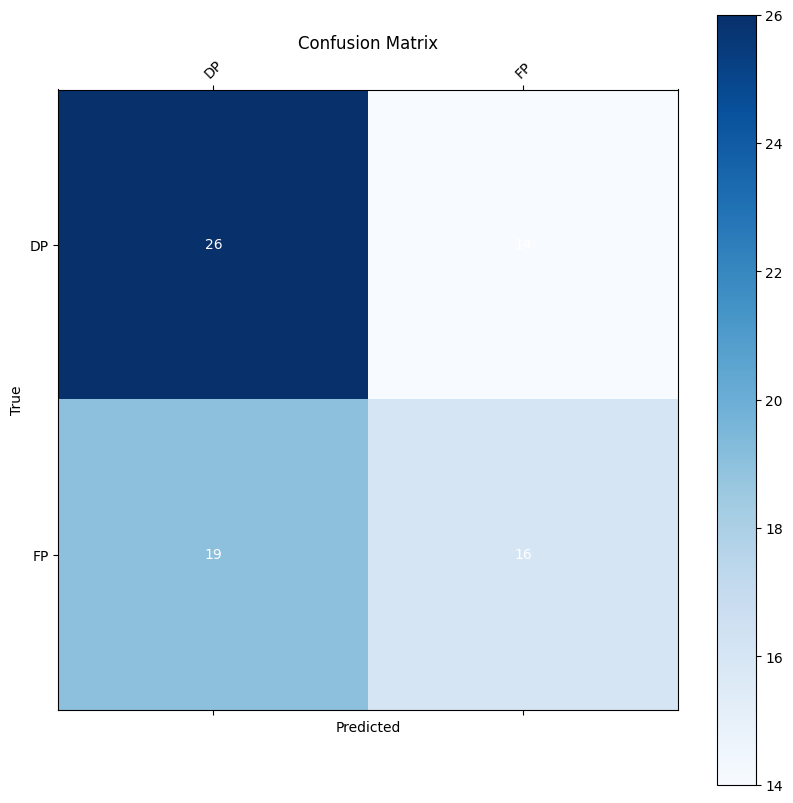

In [ ]:
#CNN model testing
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# Input shape for the CNN
input_shape = X_train.shape[1:]

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Define the SqueezeExciteBlock layer
class SqueezeExciteBlock(Layer):
    def __init__(self, ratio=16, **kwargs):
        super(SqueezeExciteBlock, self).__init__(**kwargs)
        self.ratio = ratio

    def build(self, input_shape):
        self.filters = input_shape[-1]
        self.se = models.Sequential([
            GlobalAveragePooling2D(),
            Dense(self.filters // self.ratio, activation='relu', use_bias=False),
            Dense(self.filters, activation='sigmoid', use_bias=False)
        ])
        super(SqueezeExciteBlock, self).build(input_shape)

    def call(self, inputs):
        x = self.se(inputs)
        return multiply([inputs, x])

    def compute_output_shape(self, input_shape):
        return input_shape

# Predict probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to predicted class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate and print confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Calculate Precision, Recall, F1 Score, and AUROC
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
y_true_binarized = label_binarize(y_true_classes, classes=np.unique(y_true_classes))
if y_true_binarized.shape[1] == 1:
    auroc = roc_auc_score(y_true_binarized, y_pred_probs[:, 1])
else:
    auroc = roc_auc_score(y_true_binarized, y_pred_probs, multi_class='ovr', average='weighted')
print(f"AUROC Score: {auroc}")

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.cm.Blues
cax = ax.matshow(cm, cmap=cmap)
fig.colorbar(cax)
fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

# Add labels
classes = label_encoder.classes_
ax.set_xticklabels([''] + list(classes), rotation=45)
ax.set_yticklabels([''] + list(classes))
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Hierarchical Clustering

In [ ]:
#Hierarchical Clustering
import os
import numpy as np
import pandas as pd
from PIL import Image
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, multiply, Layer
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Image Loading
def load_image(file_path):
    img = Image.open(file_path)
    img = img.convert('RGB')  # Convert image to RGB to ensure 3 color channels; necessary for tensorflow
    return np.array(img)

# Load images and preprocess
image_directory = '/content/sketches'  # Update this path to where your images are stored
data = []

for index, row in full_image_ratings_df.iterrows():
    file_path = os.path.join(image_directory, row['Image'])
    if os.path.exists(file_path):
        img = load_image(file_path)
        data.append(img)

data = np.array(data)
data = data.astype('float32') / 255.0  # Normalize pixel values to be between 0 and 1

class SqueezeExciteBlock(Layer):
    def __init__(self, ratio=16, **kwargs):
        super(SqueezeExciteBlock, self).__init__(**kwargs)
        self.ratio = ratio

    def build(self, input_shape):
        self.filters = input_shape[-1]
        self.se = models.Sequential([
            GlobalAveragePooling2D(),
            Dense(self.filters // self.ratio, activation='relu', use_bias=False),
            Dense(self.filters, activation='sigmoid', use_bias=False)
        ])
        super(SqueezeExciteBlock, self).build(input_shape)

    def call(self, inputs):
        x = self.se(inputs)
        return multiply([inputs, x])

    def compute_output_shape(self, input_shape):
        return input_shape

input_shape = data.shape[1:]

# CNN model for feature extraction
model = models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Dropout after pooling
    SqueezeExciteBlock(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
])

# Compile the model
model.compile(optimizer=Adam(), loss='mse')

# Print model summary
model.summary()

# Extract features from the images
features = model.predict(data)
from scipy.cluster.hierarchy import fcluster


In [ ]:
#Generate sample clusters

# Choose a threshold distance to cut the dendrogram
threshold =0.5
cluster_labels = fcluster(linked, threshold, criterion='distance')

# Add cluster labels to the DataFrame
full_image_ratings_df['Cluster'] = cluster_labels
print(full_image_ratings_df)

# Print 10 examples from each cluster
clusters = full_image_ratings_df['Cluster'].unique()
for cluster in clusters:
    cluster_examples = full_image_ratings_df[full_image_ratings_df['Cluster'] == cluster].sample(n=10, random_state=42, replace=True)
    print(f"Cluster {cluster} examples:")
    for idx, row in cluster_examples.iterrows():
        img_path = os.path.join(image_directory, row['Image'])
        img = Image.open(img_path).convert('L').resize((224, 224))  # Convert to grayscale and resize
        plt.figure()
        plt.imshow(img, cmap='gray')
        plt.title(f"Cluster {cluster}: {row['Image']}")
        plt.axis('off')
    plt.show()